In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/b5-model/keras/default/1/efficientnetb5.h5
/kaggle/input/dataset-ham10000/HAM10000_folders/mel/ISIC_0028582.jpg
/kaggle/input/dataset-ham10000/HAM10000_folders/mel/ISIC_0027742.jpg
/kaggle/input/dataset-ham10000/HAM10000_folders/mel/ISIC_0030032.jpg
/kaggle/input/dataset-ham10000/HAM10000_folders/mel/ISIC_0031479.jpg
/kaggle/input/dataset-ham10000/HAM10000_folders/mel/ISIC_0033624.jpg
/kaggle/input/dataset-ham10000/HAM10000_folders/mel/ISIC_0033152.jpg
/kaggle/input/dataset-ham10000/HAM10000_folders/mel/ISIC_0031417.jpg
/kaggle/input/dataset-ham10000/HAM10000_folders/mel/ISIC_0025611.jpg
/kaggle/input/dataset-ham10000/HAM10000_folders/mel/ISIC_0026352.jpg
/kaggle/input/dataset-ham10000/HAM10000_folders/mel/ISIC_0026239.jpg
/kaggle/input/dataset-ham10000/HAM10000_folders/mel/ISIC_0033239.jpg
/kaggle/input/dataset-ham10000/HAM10000_folders/mel/ISIC_0028075.jpg
/kaggle/input/dataset-ham10000/HAM10000_folders/mel/ISIC_0028520.jpg
/kaggle/input/dataset-ham10000/HAM10000_folder


# **Importing Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
import cv2
import tensorflow as tf

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **DATA Preprocessing**

In [3]:
base_skin_dir = '/kaggle/input/dataset-ham10000/HAM10000_folders'

# Dictionary mapping short codes to full lesion names
lesion_type_dict = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions'
}

# Class ID dictionary for consistency with model
CLASSES = {
    0: 'Actinic keratoses (akiec)',
    1: 'Basal cell carcinoma (bcc)',
    2: 'Benign keratosis-like lesions (bkl)',
    3: 'Dermatofibroma (df)',
    4: 'Melanoma (mel)',
    5: 'Melanocytic nevi (nv)',
    6: 'Vascular lesions (vasc)'
}

# 🔍 Collect all image paths
image_paths = glob(os.path.join(base_skin_dir, '*', '*.jpg'))
print(f"Total images found: {len(image_paths)}")

# ✅ Build mapping dictionaries
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in image_paths}
imageid_label_dict = {os.path.splitext(os.path.basename(x))[0]: os.path.basename(os.path.dirname(x)) for x in image_paths}

# ✅ Create dataframe
df = pd.DataFrame({
    'image_id': list(imageid_path_dict.keys()),
    'file_path': list(imageid_path_dict.values()),
    'label': [imageid_label_dict[i] for i in imageid_path_dict.keys()]
})

# ✅ Map to full lesion names
df['lesion_type'] = df['label'].map(lesion_type_dict)

# ✅ Shuffle for randomness
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("\n📊 Dataset Overview:")
print(df.head())
print("\n🔢 Class Distribution:")
print(df['label'].value_counts())

Total images found: 10015

📊 Dataset Overview:
       image_id                                          file_path label  \
0  ISIC_0025300  /kaggle/input/dataset-ham10000/HAM10000_folder...    nv   
1  ISIC_0028503  /kaggle/input/dataset-ham10000/HAM10000_folder...   bkl   
2  ISIC_0026937  /kaggle/input/dataset-ham10000/HAM10000_folder...    nv   
3  ISIC_0032645  /kaggle/input/dataset-ham10000/HAM10000_folder...   mel   
4  ISIC_0028547  /kaggle/input/dataset-ham10000/HAM10000_folder...    nv   

                     lesion_type  
0               Melanocytic nevi  
1  Benign keratosis-like lesions  
2               Melanocytic nevi  
3                       Melanoma  
4               Melanocytic nevi  

🔢 Class Distribution:
label
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


⚙️ Preprocessing all images...


100%|██████████| 10015/10015 [02:43<00:00, 61.38it/s]


✅ Preprocessing complete. All images saved to: /kaggle/working/preprocessed_images


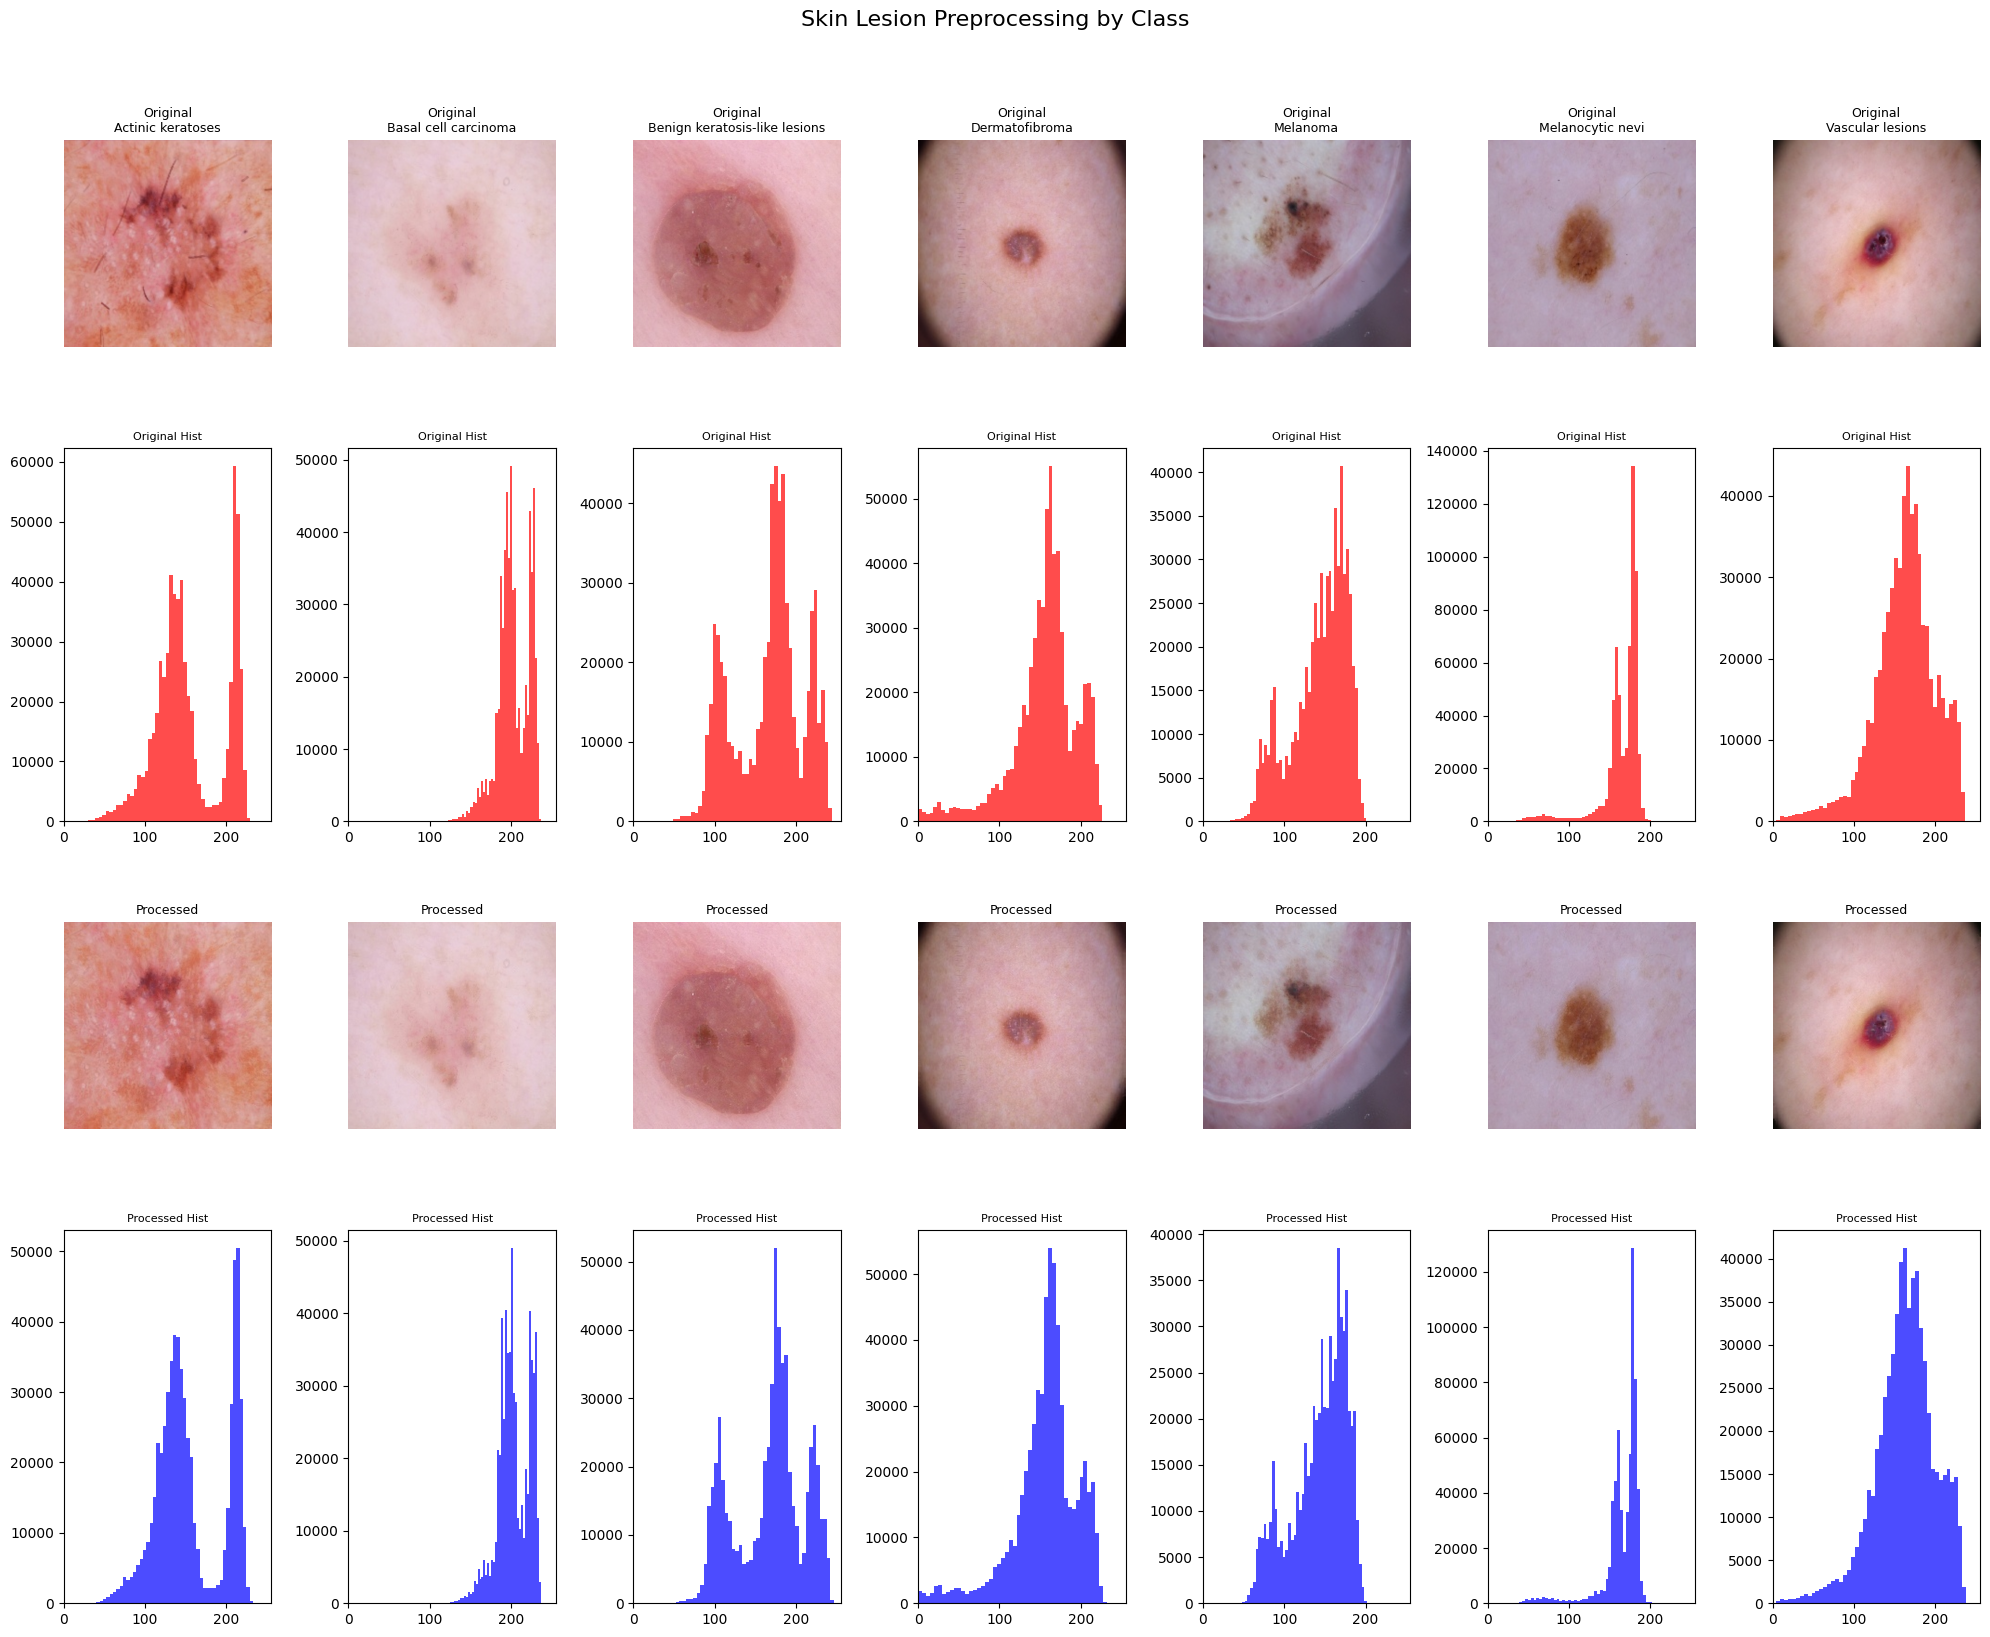

In [4]:
from tqdm import tqdm

# -------------------------
# Preprocessing function
# -------------------------
def preprocess(input_img, IMAGE_SIZE=456):
    """
    Preprocess skin lesion images:
    - Hair removal
    - Resize to IMAGE_SIZE
    """
    if isinstance(input_img, str):
        img = cv2.imread(input_img)
        if img is None:
            raise FileNotFoundError(f"Could not read image: {input_img}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = input_img
        if img.dtype != np.uint8:
            img = img.astype(np.uint8)

    # Hair removal
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (11, 11))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, hair_mask = cv2.threshold(blackhat, 15, 255, cv2.THRESH_BINARY)
    cleaned = cv2.inpaint(img, hair_mask, 1, cv2.INPAINT_TELEA)

    # Resize
    cleaned_resized = cv2.resize(cleaned, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_LANCZOS4)
    return cleaned_resized

# ===============================
# ⚙️ Step 4: Apply Preprocessing to All Images
# ===============================
output_dir = "/kaggle/working/preprocessed_images"
os.makedirs(output_dir, exist_ok=True)

processed_paths = []

print("⚙️ Preprocessing all images...")
for row in tqdm(df.itertuples(), total=len(df)):
    processed = preprocess(row.file_path)
    
    filename = os.path.basename(row.file_path)
    save_path = os.path.join(output_dir, filename)
    cv2.imwrite(save_path, cv2.cvtColor(processed, cv2.COLOR_RGB2BGR))
    
    processed_paths.append(save_path)

df["processed_path"] = processed_paths
print("✅ Preprocessing complete. All images saved to:", output_dir)

# ===============================
# 🖼️ Step 5: Visualization (7 Classes)
# ===============================
sample_images = df.groupby('label').first().reset_index()
num_classes = len(sample_images)

plt.figure(figsize=(20, 16))

for i, row in enumerate(sample_images.itertuples(), 1):
    lesion_name = lesion_type_dict[row.label]
    
    # Original
    original = cv2.imread(row.file_path)
    original = cv2.cvtColor(cv2.resize(original, (456, 456)), cv2.COLOR_BGR2RGB)
    
    # Processed
    processed = cv2.imread(row.processed_path)
    processed = cv2.cvtColor(cv2.resize(processed, (456, 456)), cv2.COLOR_BGR2RGB)
    
    # Plot Original Image
    plt.subplot(4, num_classes, i)
    plt.imshow(original)
    plt.title(f"Original\n{lesion_name}", fontsize=9)
    plt.axis('off')
    
    # Original Histogram
    plt.subplot(4, num_classes, i + num_classes)
    plt.hist(original.ravel(), bins=50, color='red', alpha=0.7)
    plt.title("Original Hist", fontsize=8)
    plt.xlim(0, 255)
    
    # Processed Image
    plt.subplot(4, num_classes, i + 2*num_classes)
    plt.imshow(processed)
    plt.title("Processed", fontsize=9)
    plt.axis('off')
    
    # Processed Histogram
    plt.subplot(4, num_classes, i + 3*num_classes)
    plt.hist(processed.ravel(), bins=50, color='blue', alpha=0.7)
    plt.title("Processed Hist", fontsize=8)
    plt.xlim(0, 255)

plt.tight_layout()
plt.suptitle("Skin Lesion Preprocessing by Class", y=1.02, fontsize=16)
plt.show()

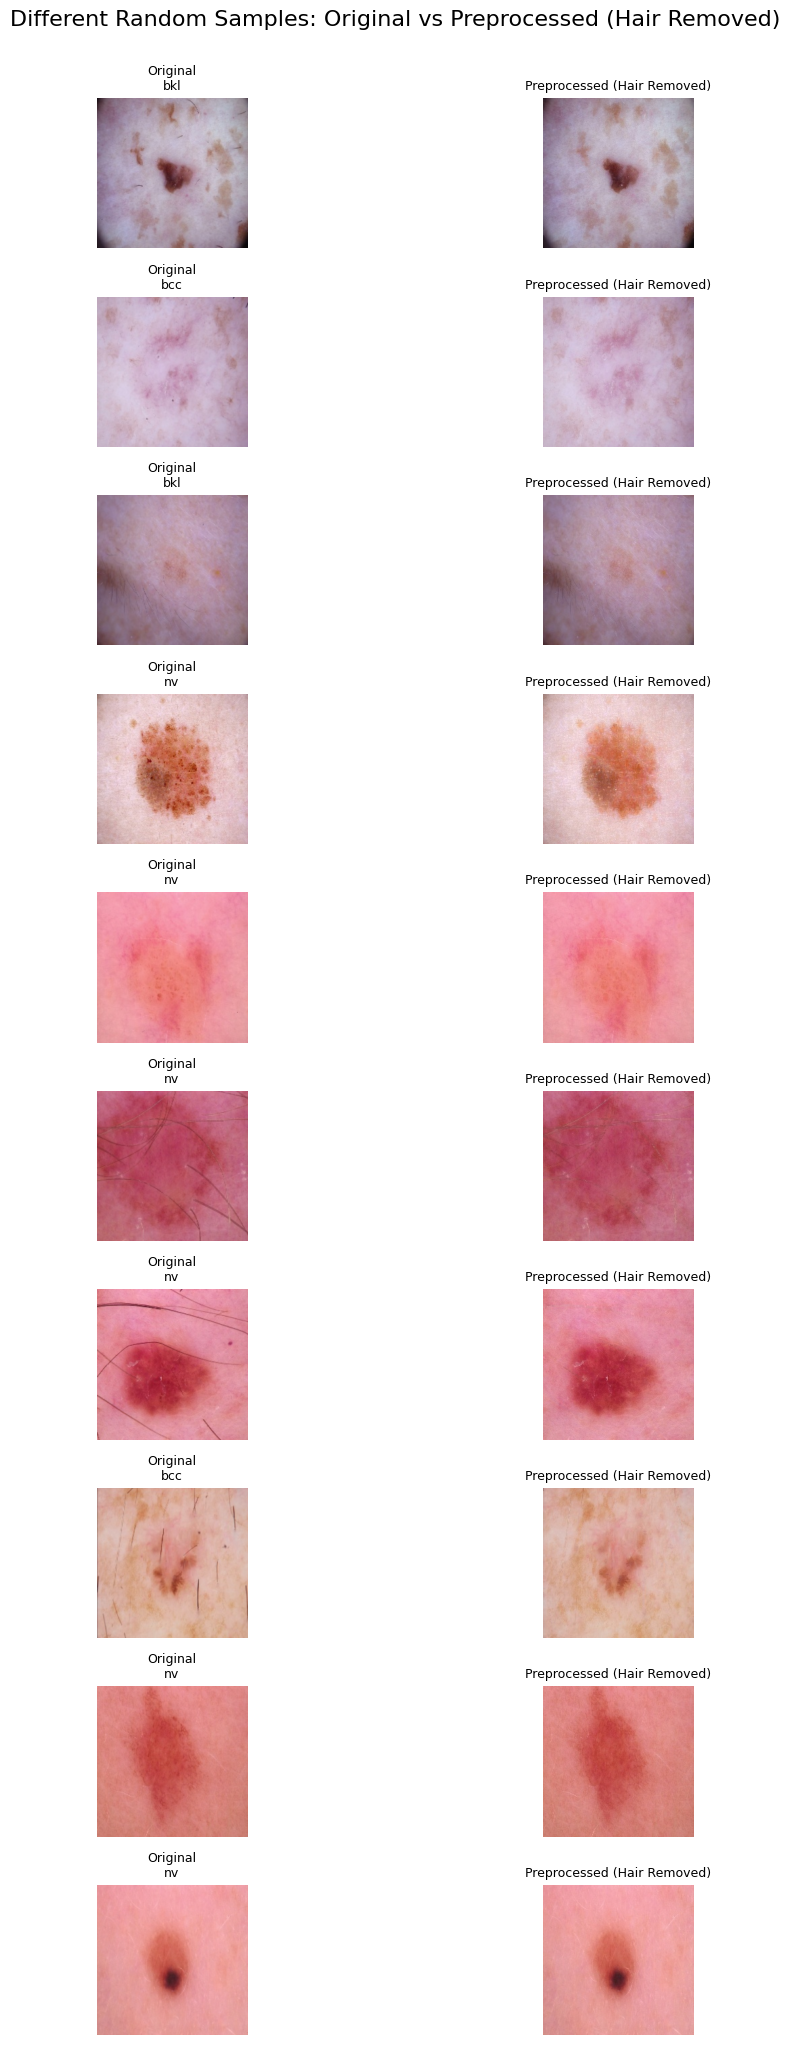

In [5]:
np.random.seed(123)  # Different from the previous seed (42)

# -------------------------
# Show 10 different random samples (Original vs Preprocessed)
# -------------------------

# Pick different random samples
n_samples = min(10, len(df))
sampled_df = df.sample(n=n_samples, random_state=123)  # Different seed

plt.figure(figsize=(12, n_samples * 2))

for idx, row in enumerate(sampled_df.itertuples()):
    # Read Original
    original = cv2.imread(row.file_path)
    original = cv2.cvtColor(cv2.resize(original, (456, 456)), cv2.COLOR_BGR2RGB)

    # Read Preprocessed
    processed = cv2.imread(row.processed_path)
    processed = cv2.cvtColor(cv2.resize(processed, (456, 456)), cv2.COLOR_BGR2RGB)

    # Plot Original
    plt.subplot(n_samples, 2, idx * 2 + 1)
    plt.imshow(original)
    plt.axis("off")
    plt.title(f"Original\n{row.label}", fontsize=9)

    # Plot Preprocessed
    plt.subplot(n_samples, 2, idx * 2 + 2)
    plt.imshow(processed)
    plt.axis("off")
    plt.title("Preprocessed (Hair Removed)", fontsize=9)

plt.tight_layout()
plt.suptitle("Different Random Samples: Original vs Preprocessed (Hair Removed)", y=1.02, fontsize=16)
plt.show()

# **Frequency Distribution of Classes**

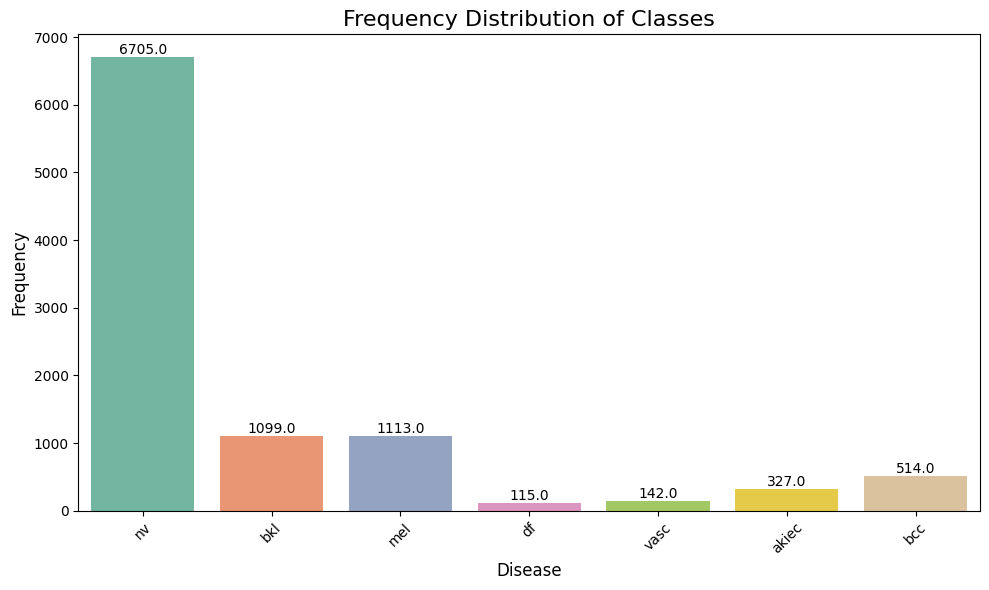

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use the correct DataFrame and column name
plt.figure(figsize=(10,6))
ax = sns.countplot(x='label', data=df, palette='Set2')  # replace 'label' with 'dx' if needed

plt.xlabel('Disease', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency Distribution of Classes', fontsize=16)
plt.xticks(rotation=45)

# Annotate counts on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


# **Data Splitting**

In [7]:
from sklearn.model_selection import train_test_split

# Use correct column names
X = df['file_path'].values      # image paths
y = df['label'].values          # class labels (short codes)

# 1. Split 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# 2. Split temp into 10% val and 20% test (relative to original)
# temp is 30% of original, so to get val=10% and test=20% we split temp as 1/3 val, 2/3 test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42)

# Check sizes
print(f"Train size: {len(X_train)} ({len(X_train)/len(X):.2%})")
print(f"Validation size: {len(X_val)} ({len(X_val)/len(X):.2%})")
print(f"Test size: {len(X_test)} ({len(X_test)/len(X):.2%})")


Train size: 7010 (70.00%)
Validation size: 1001 (10.00%)
Test size: 2004 (20.01%)


# **Combine into DataFrames**

In [8]:
train_df = pd.DataFrame({'path': X_train, 'label': y_train})
val_df   = pd.DataFrame({'path': X_val,   'label': y_val})
test_df  = pd.DataFrame({'path': X_test,  'label': y_test})

# Convert labels to string for generators
for d in [train_df, val_df, test_df]:
    d['label'] = d['label'].astype(str)

# -------------------
# Map to preprocessed path
# -------------------
preprocessed_dir = "/kaggle/working/preprocessed_images"

for d in [train_df, val_df, test_df]:
    d['processed_path'] = d['path'].apply(lambda x: os.path.join(preprocessed_dir, os.path.basename(x)))

# ✅ Now use `processed_path` column for your generators
print("Example preprocessed path:", train_df['processed_path'].iloc[0])

Example preprocessed path: /kaggle/working/preprocessed_images/ISIC_0032050.jpg


# **Augmentation**

In [9]:
class_counts = train_df['label'].value_counts()
max_count = class_counts.max()
print("Original class distribution:\n", class_counts)

Original class distribution:
 label
nv       4693
mel       779
bkl       769
bcc       360
akiec     229
vasc       99
df         81
Name: count, dtype: int64


In [10]:
# ===============================
import shutil
from collections import Counter
import random
import os
import cv2
import numpy as np
import pandas as pd

# ------------------------
# Settings
# ------------------------
IMG_SIZE = 456  
balanced_dir = "/kaggle/working/balanced_train_cleaned"
os.makedirs(balanced_dir, exist_ok=True)

# Check current distribution
class_counts = train_df['label'].value_counts()
majority_class = class_counts.idxmax()
majority_count = class_counts.max()

print(f"Majority class: {majority_class} with {majority_count} samples\n")

balanced_paths = []
balanced_labels = []

# ------------------------
# Helper Functions
# ------------------------
def resize_img(img):
    """Resize image to (IMG_SIZE, IMG_SIZE)."""
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

def rotate_image(image, angle):
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    rotated = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)
    return resize_img(rotated)

def flip_image(image, mode="h"):
    if mode == "h": flipped = cv2.flip(image, 1)
    elif mode == "v": flipped = cv2.flip(image, 0)
    elif mode == "hv": flipped = cv2.flip(image, -1)
    else: flipped = image
    return resize_img(flipped)

def adjust_brightness(image, factor=1.2):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float64)
    hsv[...,1] = np.clip(hsv[...,1]*factor, 0, 255)
    hsv[...,2] = np.clip(hsv[...,2]*factor, 0, 255)
    bright = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
    return resize_img(bright)

def adjust_contrast(image, factor=1.2):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=factor, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    contrasted = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return resize_img(contrasted)

# ------------------------
# Randomized Wrappers (Safe Only)
# ------------------------
def random_rotate(img): return rotate_image(img, random.choice([15,30,-15,-30]))
def random_flip(img): return flip_image(img, random.choice(["h","v"]))
def random_brightness(img): return adjust_brightness(img, random.uniform(0.8, 1.2))
def random_contrast(img): return adjust_contrast(img, random.uniform(1.0, 1.8))

augmentations = [
    ("rot", random_rotate),
    ("flip", random_flip),
    ("bright", random_brightness),
    ("contrast", random_contrast)
]

def apply_random_augmentation_combinations(img, num_augmentations=2):
    selected_augs = random.sample(augmentations, min(num_augmentations, len(augmentations)))
    augmented_img, aug_names = img.copy(), []
    for aug_name, aug_fn in selected_augs:
        augmented_img = aug_fn(augmented_img)
        aug_names.append(aug_name)
    return resize_img(augmented_img), "_".join(aug_names)

def apply_single_random_augmentation(img):
    aug_name, aug_fn = random.choice(augmentations)
    return resize_img(aug_fn(img)), aug_name

# ------------------------
# Balance Dataset
# ------------------------
for label, count in class_counts.items():
    class_paths = train_df[train_df['label'] == label]['processed_path'].values
    target_count = majority_count
    class_dir = os.path.join(balanced_dir, label)
    os.makedirs(class_dir, exist_ok=True)

    # Copy originals
    for img_path in class_paths:
        fname = os.path.basename(img_path)
        dst = os.path.join(class_dir, fname)
        shutil.copy(img_path, dst)
        balanced_paths.append(dst)
        balanced_labels.append(label)

    # Augment minority classes
    if count < target_count:
        n_needed = target_count - count
        augs_per_image = max(1, n_needed // count)
        remainder = n_needed % count

        print(f"Class {label}: Need {n_needed} augmentations → {augs_per_image} per image + {remainder} extra")

        for img_idx, img_path in enumerate(class_paths):
            img = cv2.imread(img_path)
            if img is None:
                print(f"⚠️ Skipping unreadable file: {img_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            current_augs = augs_per_image + (1 if img_idx < remainder else 0)

            for aug_idx in range(current_augs):
                if random.choice([True, False]):
                    aug_img, aug_str = apply_random_augmentation_combinations(img, random.randint(1, 2))
                else:
                    aug_img, aug_str = apply_single_random_augmentation(img)

                out_name = f"{os.path.splitext(os.path.basename(img_path))[0]}_{aug_str}_{img_idx}_{aug_idx}.jpg"
                out_path = os.path.join(class_dir, out_name)
                cv2.imwrite(out_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
                balanced_paths.append(out_path)
                balanced_labels.append(label)

# ------------------------
# Save Balanced DataFrame
# ------------------------
balanced_train_df = pd.DataFrame({"path": balanced_paths, "label": balanced_labels})
print("\n✅ Balanced dataset distribution:")
print(balanced_train_df['label'].value_counts())
print(f"\nExample balanced path: {balanced_train_df['path'].iloc[0]}")
print(f"Total images after balancing: {len(balanced_train_df)}")

Majority class: nv with 4693 samples

Class mel: Need 3914 augmentations → 5 per image + 19 extra
Class bkl: Need 3924 augmentations → 5 per image + 79 extra
Class bcc: Need 4333 augmentations → 12 per image + 13 extra
Class akiec: Need 4464 augmentations → 19 per image + 113 extra
Class vasc: Need 4594 augmentations → 46 per image + 40 extra
Class df: Need 4612 augmentations → 56 per image + 76 extra

✅ Balanced dataset distribution:
label
nv       4693
mel      4693
bkl      4693
bcc      4693
akiec    4693
vasc     4693
df       4693
Name: count, dtype: int64

Example balanced path: /kaggle/working/balanced_train_cleaned/nv/ISIC_0032050.jpg
Total images after balancing: 32851


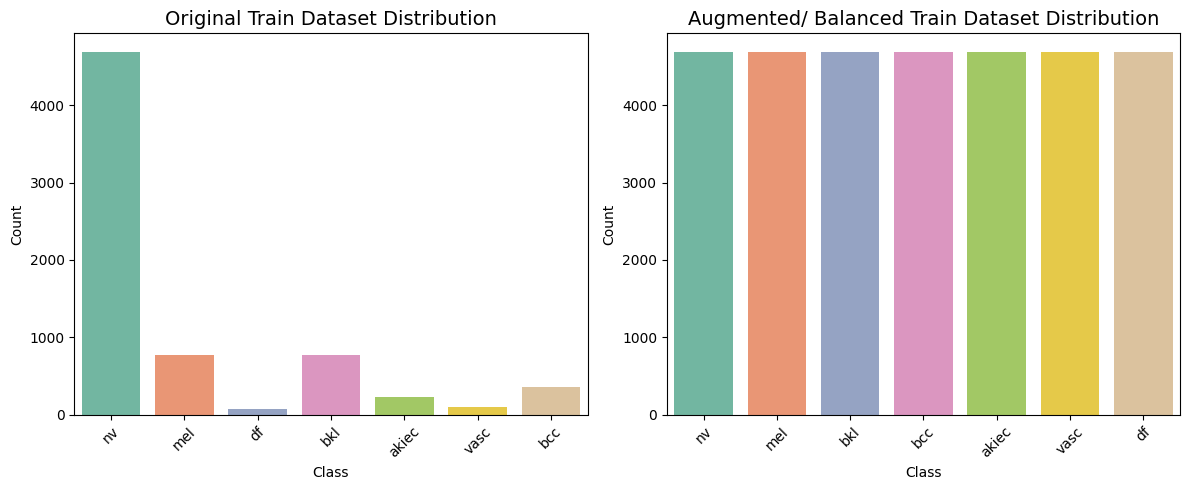

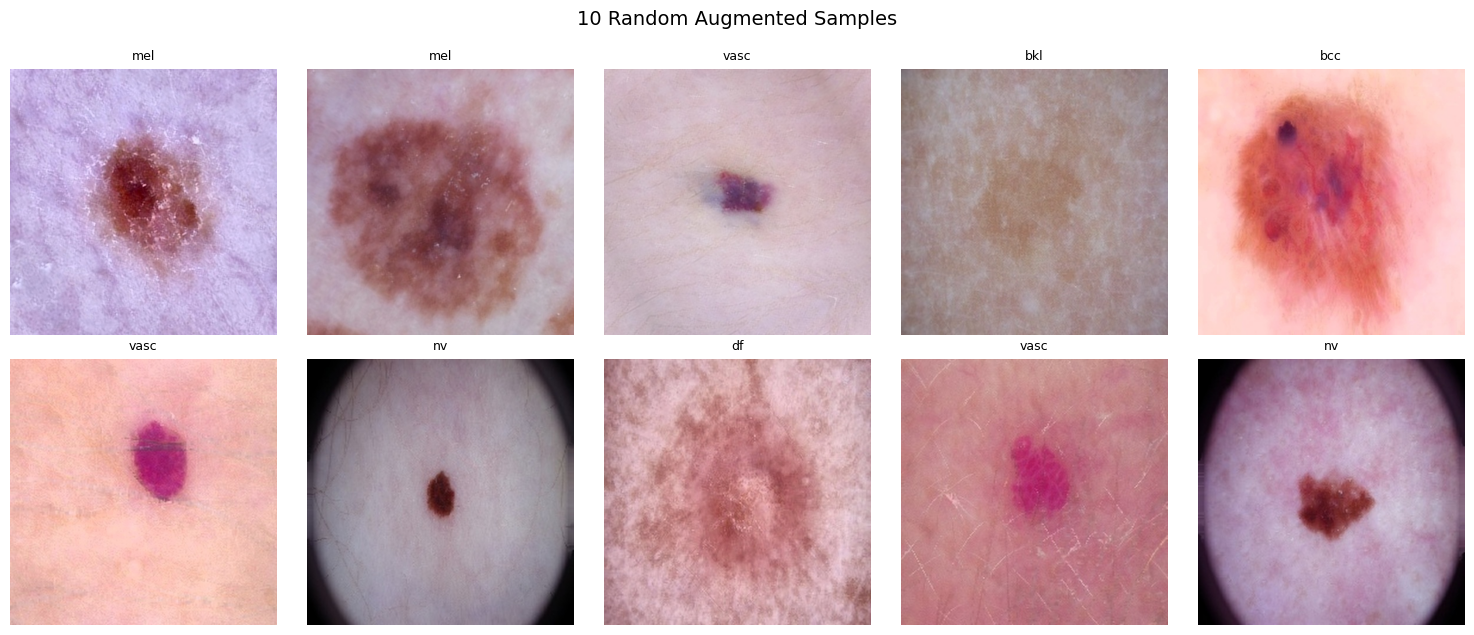

In [11]:
# -------------------------------
# 1. Plot original vs balanced class distribution
# -------------------------------
plt.figure(figsize=(12,5))

# Original train distribution
plt.subplot(1,2,1)
sns.countplot(x='label', data=train_df, palette='Set2')
plt.title("Original Train Dataset Distribution", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Balanced (augmented) train distribution
plt.subplot(1,2,2)
sns.countplot(x='label', data=balanced_train_df, palette='Set2')
plt.title("Augmented/ Balanced Train Dataset Distribution", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

import random

# -------------------------------
# Show 10 random augmented samples
# -------------------------------
sampled_df = balanced_train_df.sample(n=10, random_state=42)

plt.figure(figsize=(15, 6))

for idx, row in enumerate(sampled_df.itertuples()):
    img = cv2.imread(row.path)  
    img = cv2.cvtColor(cv2.resize(img, (456,456)), cv2.COLOR_BGR2RGB)
    plt.subplot(2, 5, idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{row.label}", fontsize=9)

plt.tight_layout()
plt.suptitle("10 Random Augmented Samples", y=1.05, fontsize=14)
plt.show()


In [12]:
print(balanced_train_df.groupby("label").size())

label
akiec    4693
bcc      4693
bkl      4693
df       4693
mel      4693
nv       4693
vasc     4693
dtype: int64


# **One-hot encode the labels And Data Generators (for categorical classification)**

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# -----------------------
# Configuration
# -----------------------
IMAGE_SIZE = 456
BATCH_SIZE = 32
# Create the ordered list of class names for flow_from_dataframe
class_list = [CLASSES[i].split('(')[1][:-1] for i in range(len(CLASSES))]
# This extracts ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

print("Class order:", class_list)

# -----------------------
# Train generator (no augmentation — only preprocess)
# -----------------------
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=balanced_train_df,
    x_col="path",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    classes=class_list,    # ✅ enforce consistent order
    shuffle=True
)

# -----------------------
# Validation generator
# -----------------------
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="processed_path",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    classes=class_list,    # ✅ enforce same order
    shuffle=False
)

# -----------------------
# Test generator
# -----------------------
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="processed_path",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    classes=class_list,    # ✅ enforce same order
    shuffle=False
)

# -----------------------
# Debug Info
# -----------------------
print("\n--- Generator Summary ---")
print("Train samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)
print("Test samples:", test_generator.samples)
print("Class indices:", train_generator.class_indices)


Class order: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Found 32851 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.
Found 2004 validated image filenames belonging to 7 classes.

--- Generator Summary ---
Train samples: 32851
Validation samples: 1001
Test samples: 2004
Class indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


# **Build and compile the EfficientNetB5 model**

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# ------------------------
# Custom Focal Loss
# ------------------------
def categorical_focal_loss(gamma=3.0, alpha=0.5):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        prob = tf.reduce_sum(y_true * y_pred, axis=-1)
        return alpha * (1 - prob) ** gamma * cross_entropy
    return loss

# ------------------------
# Model Builder
# ------------------------
def build_single_model(base_model, num_classes=7):
    x = GlobalAveragePooling2D()(base_model.output)   
    x = Dense(512, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation="softmax")(x)
    return Model(inputs=base_model.input, outputs=output)

# ------------------------
# Single EfficientNetB5 Model
# ------------------------
def build_efficientnetb5(num_classes=7, IMAGE_SIZE=456):
    base_b5 = EfficientNetB5(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # Fine-tune some layers
    for layer in base_b5.layers[:200]:
        layer.trainable = False
    for layer in base_b5.layers[200:]:
        layer.trainable = True

    model = build_single_model(base_b5, num_classes)
    return model

# ------------------------
# Instantiate & Compile
# ------------------------
IMAGE_SIZE = 456
model = build_efficientnetb5(num_classes=7, IMAGE_SIZE=IMAGE_SIZE)

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=categorical_focal_loss(gamma=3.0, alpha=0.5),
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.TopKCategoricalAccuracy(k=3, name="top3_acc"),
    ]
)

model.summary()


115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 456, 456, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 456, 456, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 456, 456, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 456, 456, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 457, 457, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 228, 228, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 228, 228, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 228, 228, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 228, 228, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 228, 228, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 228, 228, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 29,731,326 (113.42 MB)

 Trainable params: 29,061,959 (110.86 MB)

 Non-trainable params: 669,367 (2.55 MB)

# **Train the model**

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2,min_lr=1e-7)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 1438s 1s/step - accuracy: 0.2181 - auc: 0.5889 - loss: 1.1055 - top3_acc: 0.5364 - val_accuracy: 0.5694 - val_auc: 0.8793 - val_loss: 0.4543 - val_top3_acc: 0.8521 - learning_rate: 1.0000e-05
Epoch 2/30
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 1311s 1s/step - accuracy: 0.4193 - auc: 0.7838 - loss: 0.7036 - top3_acc: 0.7469 - val_accuracy: 0.6474 - val_auc: 0.9252 - val_loss: 0.3825 - val_top3_acc: 0.8991 - learning_rate: 1.0000e-05
Epoch 3/30
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 1311s 1s/step - accuracy: 0.5404 - auc: 0.8667 - loss: 0.5301 - top3_acc: 0.8481 - val_accuracy: 0.6763 - val_auc: 0.9405 - val_loss: 0.3506 - val_top3_acc: 0.9161 - learning_rate: 1.0000e-05
Epoch 4/30
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 1309s 1s/step - accuracy: 0.6197 - auc: 0.9083 - loss: 0.4354 - top3_acc: 0.8964 - val_accuracy: 0.6983 - val_auc: 0.9477 - val_loss: 0.3322 - val_top3_acc: 0.9311 - learning_rate: 1.0000e-05
Epoch 5/30
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 1311s 1s/step - accura

In [18]:
# Example: Find epoch with the highest validation accuracy
best_epoch = np.argmax(history.history['accuracy']) + 1
best_acc = history.history['accuracy'][best_epoch - 1]

print(f"Best Epoch: {best_epoch}")
print(f"Accuracy at Best Epoch: {best_acc:.4f}")

Best Epoch: 20
Accuracy at Best Epoch: 0.9385


In [19]:
import zipfile, os

model.save("efficientnetb5_best_model.h5")

with zipfile.ZipFile("efficientnetb5_best_model.zip", "w", zipfile.ZIP_DEFLATED) as zipf:
    zipf.write("efficientnetb5_best_model.h5")

# **Plot Training History (Accuracy & Loss)**

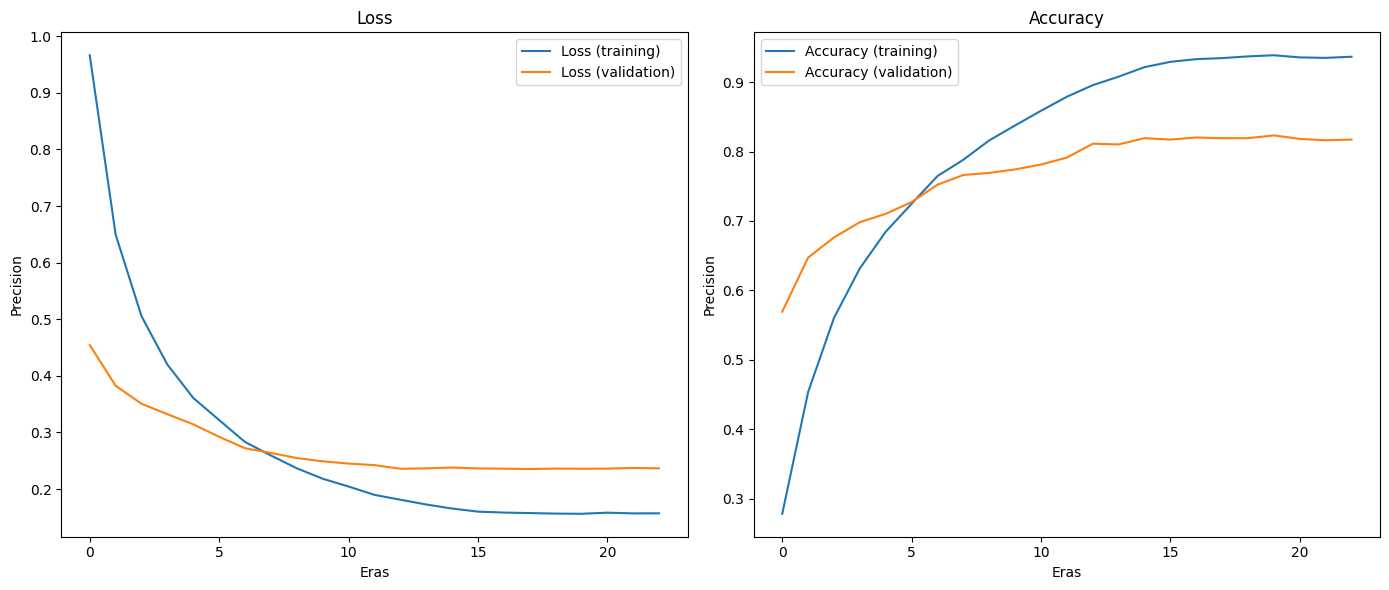

In [20]:
# Training curve
plt.figure(figsize=(14, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (training)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.title('Loss')
plt.xlabel('Eras')
plt.ylabel('Precision')
plt.legend()

# Precision curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy (training)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation)')
plt.title('Accuracy')
plt.xlabel('Eras')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()


# **Evaluate the Model on Test Data**

In [21]:
results = model.evaluate(test_generator)
print(dict(zip(model.metrics_names, results)))


63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 952ms/step - accuracy: 0.8523 - auc: 0.9868 - loss: 0.2090 - top3_acc: 0.9856
{'loss': 0.22200490534305573, 'compile_metrics': 0.8393213748931885}


# **Confusion Metrix**

63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 710ms/step
Classification Report:

              precision    recall  f1-score   support

       akiec       0.66      0.69      0.68        65
         bcc       0.73      0.80      0.76       103
         bkl       0.76      0.66      0.71       220
          df       0.81      0.59      0.68        22
         mel       0.53      0.70      0.61       223
          nv       0.94      0.91      0.92      1342
        vasc       0.89      0.83      0.86        29

    accuracy                           0.84      2004
   macro avg       0.76      0.74      0.75      2004
weighted avg       0.85      0.84      0.84      2004



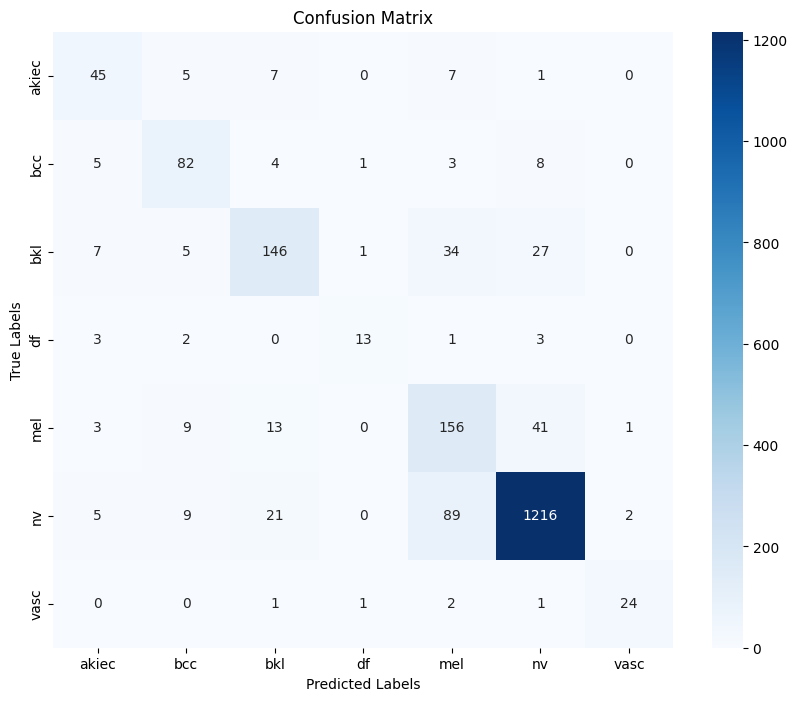

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Step 1: Get predicted probabilities
y_prob =  model.predict(test_generator)

# Step 2: Convert probabilities to predicted class indices
y_pred = np.argmax(y_prob, axis=1)

# Step 3: Get true labels from the generator
y_true = test_generator.classes

# Step 4: Get label names from generator
labels = list(test_generator.class_indices.keys())

# Step 5: Print Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# Step 6: Plot Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

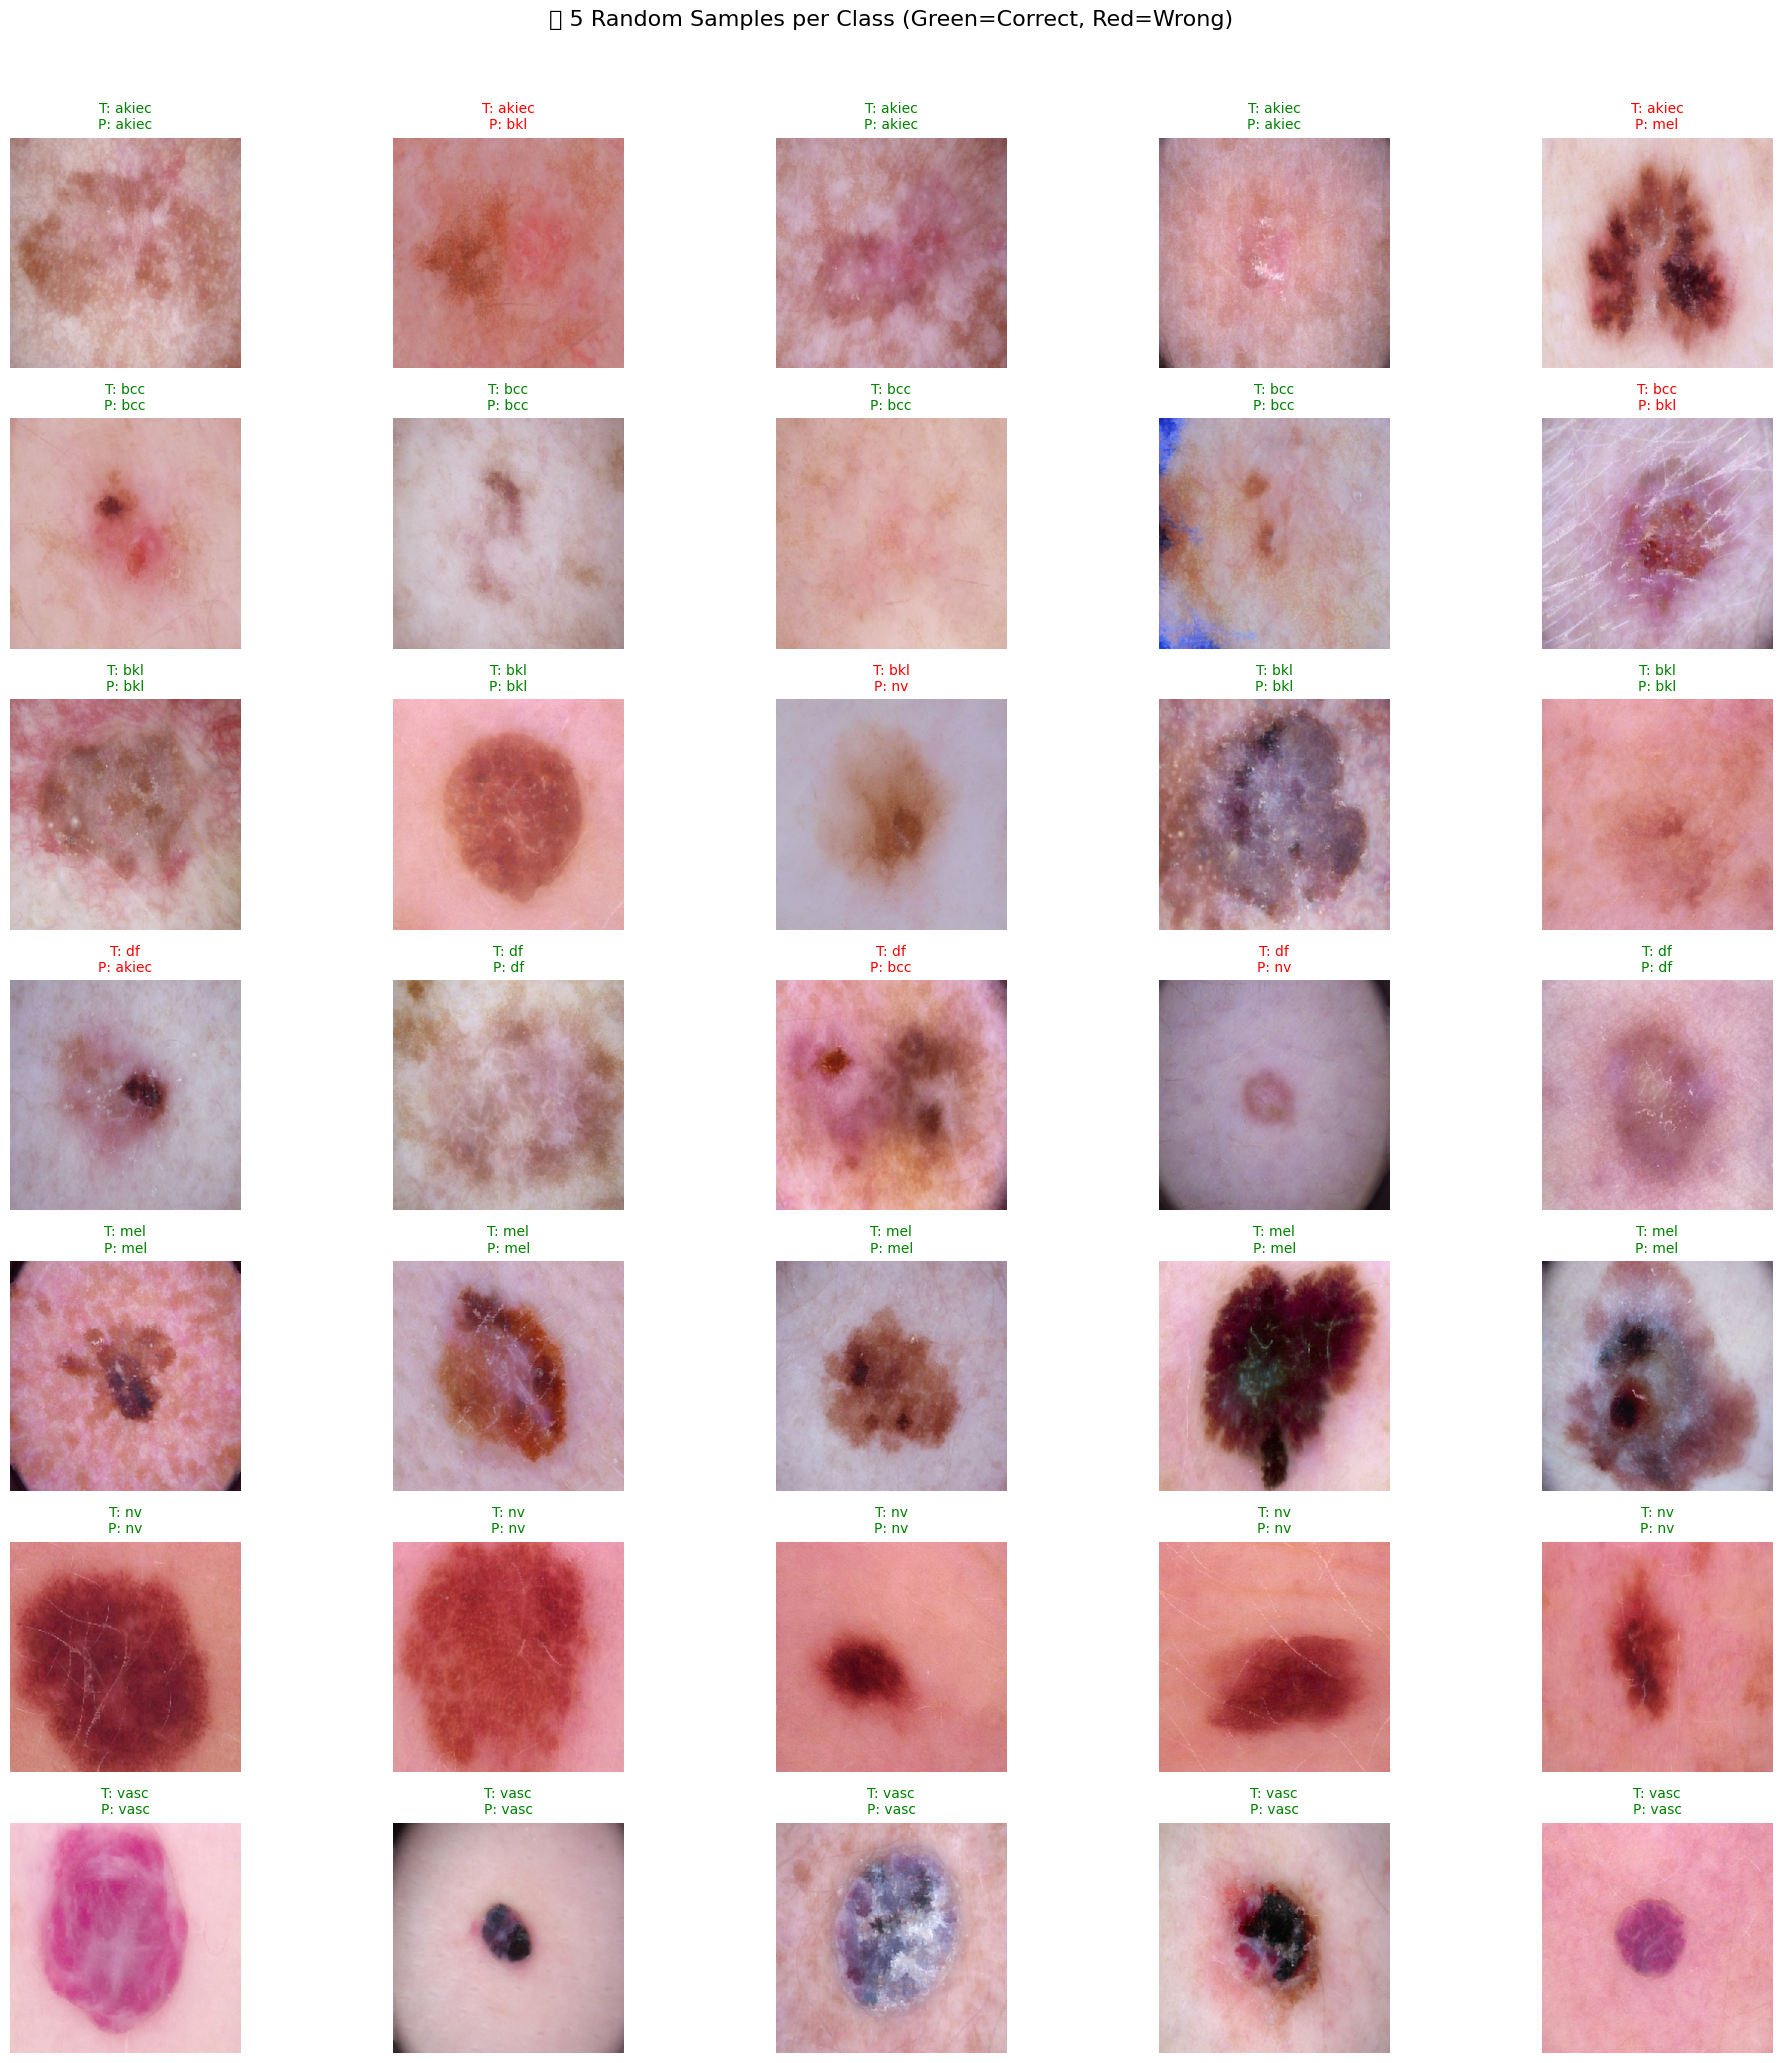

In [23]:
import matplotlib.pyplot as plt
import random
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Setup ---
num_samples_per_class = 5  # how many images per class
unique_classes = np.unique(y_true)

# --- Collect 5 random indices per class ---
selected_indices = []
for cls in unique_classes:
    cls_indices = np.where(y_true == cls)[0]
    cls_sample = random.sample(list(cls_indices), min(num_samples_per_class, len(cls_indices)))
    selected_indices.extend(cls_sample)

# --- Plot all selected samples ---
plt.figure(figsize=(20, len(unique_classes) * 3))

for i, idx in enumerate(selected_indices):
    img_path = test_generator.filepaths[idx]
    img = image.load_img(img_path, target_size=(380, 380))
    img_array = image.img_to_array(img) / 255.0

    true_class = labels[y_true[idx]]
    pred_class = labels[y_pred[idx]]
    color = "green" if true_class == pred_class else "red"

    plt.subplot(len(unique_classes), num_samples_per_class, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"T: {true_class}\nP: {pred_class}", color=color, fontsize=10)

plt.suptitle("🎯 5 Random Samples per Class (Green=Correct, Red=Wrong)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
